# 1. Import Library yang Diperlukan

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

- Insight: Library yang diimport ini diperlukan untuk seluruh pipeline analisis, mulai dari pemrosesan data, visualisasi, pelatihan model, hingga evaluasi dan penyimpanan model.

# 2. Data Gathering

In [11]:
# Memuat dataset saham
file_paths = ['./DataHistorisBBCA.csv', './DataHistorisBBRI.csv', './DataHistorisBMRI.csv', './DataHistorisASII.csv', './DataHistorisANTM.csv']

# Membaca dataset dan menggabungkan semua data menjadi satu DataFrame
dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes)

# Menampilkan 5 data pertama
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,01/10/2024,10.475,10.400,10.550,10.325,"265,93M","1,45%"
1,01/09/2024,10.325,10.375,10.950,10.125,"1,63B","0,00%"
2,01/08/2024,10.325,10.200,10.500,9.875,"1,34B","0,49%"
3,01/07/2024,10.275,9.850,10.425,9.800,"1,38B","3,53%"
4,01/06/2024,9.925,9.350,9.975,9.050,"1,47B","7,30%"


- Insight: Langkah pertama adalah mengimpor dataset yang sesuai, memastikan format data benar, dan siap untuk diproses lebih lanjut.

# 3. Data Wrangling

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 119
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     600 non-null    object 
 1   Terakhir    600 non-null    float64
 2   Pembukaan   600 non-null    float64
 3   Tertinggi   600 non-null    float64
 4   Terendah    600 non-null    float64
 5   Vol.        600 non-null    object 
 6   Perubahan%  600 non-null    object 
dtypes: float64(4), object(3)
memory usage: 37.5+ KB


In [13]:
from io import StringIO

# Mengubah kolom 'Tanggal' menjadi format datetime 
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

def clean_volume(column):
    # Menghapus 'M' dan 'B', mengganti ',' dengan '', dan mengonversi ke float
    column = column.str.replace('M', 'e6', regex=False)  # Mengganti 'M' dengan juta
    column = column.str.replace('B', 'e9', regex=False)  # Mengganti 'B' dengan milyar
    column = column.str.replace('.', '', regex=False)  # Menghapus titik
    column = column.str.replace(',', '.', regex=False)  # Mengganti ',' dengan '.'
    return column.astype(float)

# Menggunakan fungsi untuk membersihkan kolom Volume
df['Vol.'] = clean_volume(df['Vol.'])

# Mengubah kolom Perubahan% dengan menghapus '%' dan mengganti ',' dengan '.'
df['Perubahan%'] = df['Perubahan%'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Periksa hasil
print(df[['Tanggal', 'Vol.', 'Perubahan%']].head())

# Memeriksa tipe data
df.info()


     Tanggal          Vol.  Perubahan%
0 2024-01-10  2.659300e+08        1.45
1 2024-01-09  1.630000e+09        0.00
2 2024-01-08  1.340000e+09        0.49
3 2024-01-07  1.380000e+09        3.53
4 2024-01-06  1.470000e+09        7.30
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 119
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tanggal     600 non-null    datetime64[ns]
 1   Terakhir    600 non-null    float64       
 2   Pembukaan   600 non-null    float64       
 3   Tertinggi   600 non-null    float64       
 4   Terendah    600 non-null    float64       
 5   Vol.        600 non-null    float64       
 6   Perubahan%  600 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 37.5 KB


In [14]:
df.isnull().sum()

Tanggal       0
Terakhir      0
Pembukaan     0
Tertinggi     0
Terendah      0
Vol.          0
Perubahan%    0
dtype: int64

In [17]:
df.to_csv('saham_cleaned_formatted.csv', index=False)

- Data wrangling memastikan data yang digunakan untuk analisis bersih dan bebas dari error yang bisa memengaruhi hasil model, seperti mengubah tipe data yang nantinya akan diuji korelasinya, lalu melakukan pengecekan terhadap nilai null.

# 4. EDA

## Korelasi Antar Fitur

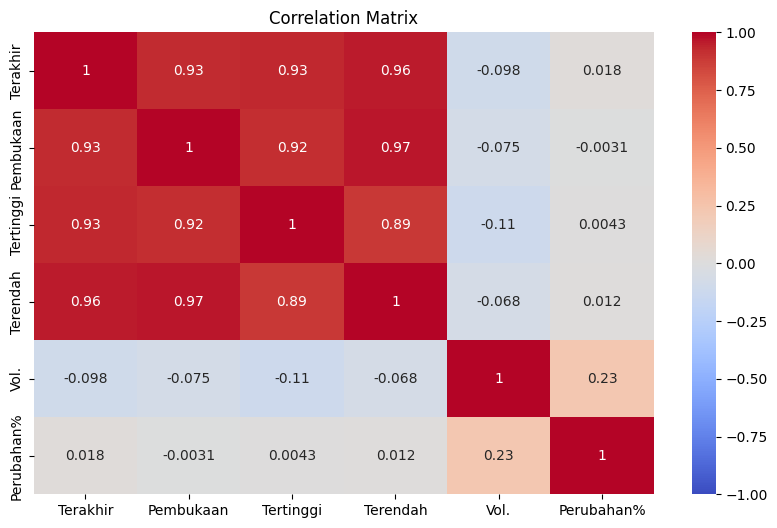

In [18]:
# Memilih hanya kolom numerik
numeric_df = df.select_dtypes(include='number')

# Menghitung matriks korelasi
corr_matrix = numeric_df.corr()

# Visualisasi matriks korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Pair Plot

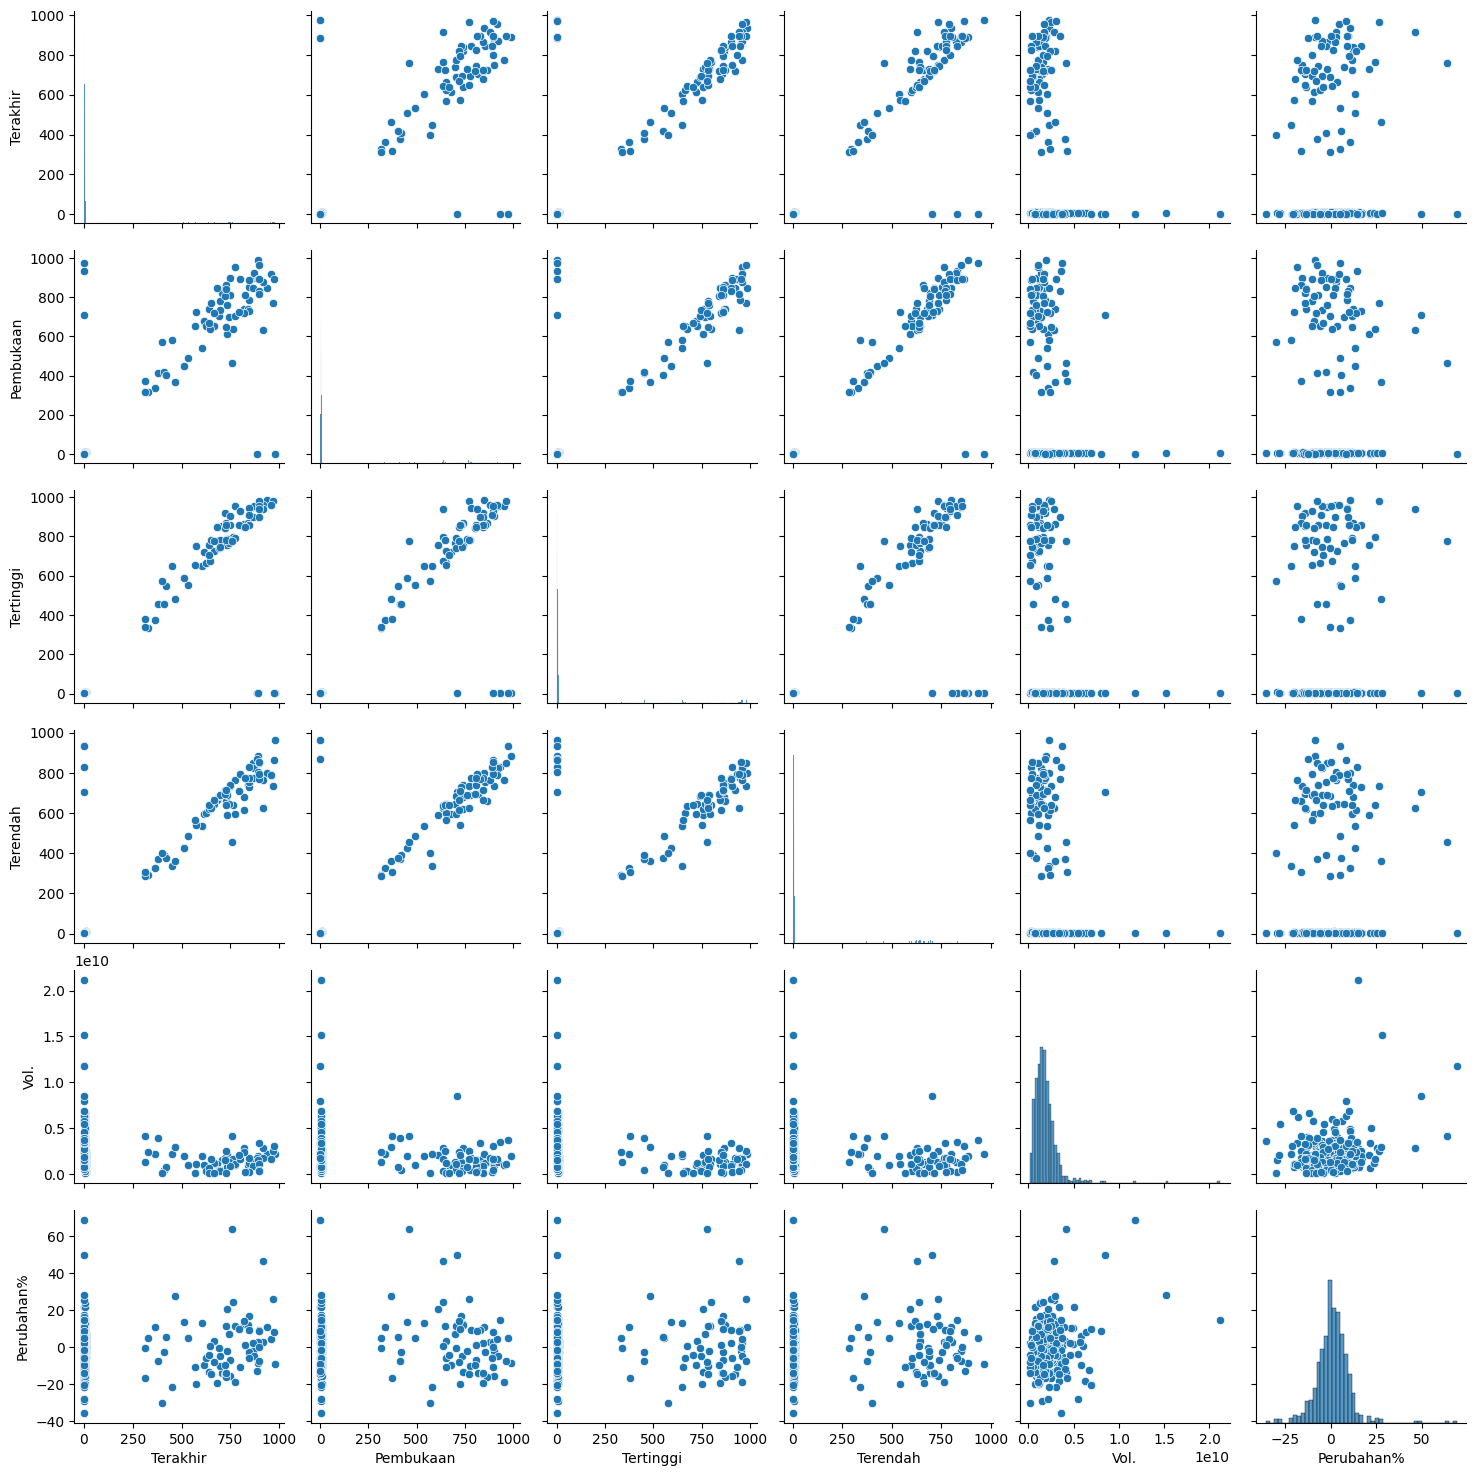

In [19]:
sns.pairplot(df)

- EDA adalah langkah kunci untuk memahami struktur data. Dari sini, Anda dapat melihat fitur mana yang memiliki korelasi kuat dengan variabel target, yang akan membantu memilih variabel input yang tepat untuk model.

# 5. Training dan Testing Data

In [21]:
# Memilih fitur (X) dan target (y)
X = df[['Pembukaan', 'Tertinggi', 'Terendah', 'Vol.']]
y = df['Terakhir']  # Target adalah harga penutupan (Terakhir)

# Membagi data menjadi training dan testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran dataset
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (480, 4)
Testing data size: (120, 4)


- Insight : Membagi data ini penting untuk menilai kinerja model pada data yang tidak pernah dilihat sebelumnya. Hal ini membantu menghindari overfitting, di mana model mungkin bekerja sangat baik pada data latih tetapi buruk pada data baru.

# 6. Training Linear Regression Model

In [22]:
# Inisialisasi model regresi linear
model = LinearRegression()

# Melatih model dengan data training
model.fit(X_train, y_train)

# Menampilkan koefisien model
print("Koefisien regresi:", model.coef_)
print("Intercept:", model.intercept_)

Koefisien regresi: [-5.47189778e-01  5.95445754e-01  9.92988085e-01 -1.18854848e-09]
Intercept: 2.0852857719720816


- Koefisien negatif (-) menunjukkan bahwa jika nilai fitur tersebut meningkat, variabel target cenderung menurun. Dalam hal ini, peningkatan pada Fitur 1 akan menurunkan nilai prediksi dari variabel target.
- Koefisien positif (+) menunjukkan bahwa peningkatan nilai fitur tersebut akan meningkatkan variabel target. Misalnya, Fitur 2 dan Fitur 3 berpengaruh positif terhadap variabel target.
- Koefisien sangat kecil atau mendekati nol (-1.19e-09) pada Fitur 4 menunjukkan bahwa fitur ini hampir tidak mempengaruhi variabel target. Fitur tersebut bisa dianggap tidak signifikan dalam memprediksi variabel target.

# 7. Membuat Prediksi

In [23]:
# Membuat prediksi pada data testing
y_pred = model.predict(X_test)

# Menghitung MSE dan R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 7352.891449772774
R-squared: 0.9007435356624821


In [24]:
# Membuat prediksi pada data baru (misalnya, data testing)
predictions = model.predict(X_test)

# Menampilkan beberapa prediksi vs nilai aktual
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(df_pred.head())

     Actual   Predicted
110    2.58    2.323784
59     6.50    8.017616
85   640.00  661.584283
77     4.54    4.620407
61     4.02    3.897709


- MSE yang rendah dan R-squared yang tinggi (dekat dengan 1) menunjukkan bahwa model memiliki kinerja yang baik dan dapat memprediksi variabel target dengan akurasi yang tinggi

# 8. Menyimpan Model

In [51]:
import joblib

# Menyimpan model ke file
joblib.dump(model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

- Model yang telah dilatih disimpan menggunakan joblib.dump(), sehingga dapat digunakan kembali tanpa perlu dilatih ulang. Pada file ini, model disimpan dengan nama linear_regression_model.pkl.